# Import

In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor

import lightning as L
from lightning.pytorch.callbacks import LearningRateMonitor
from lightning.pytorch.loggers import TensorBoardLogger
import clip

from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import io
from datetime import datetime

import sys
import os

sys.path.append(os.path.join(os.path.dirname(os.path.abspath("")), "code"))
import lookup_dict as LD
import dataset as D

In [7]:
root_path = "/home/choi/BrainDecoder/"
dataset_path = os.path.join(root_path, "dataset")
images_dataset_path = os.path.join(dataset_path, "imageNet_images")
eeg_dataset_path = os.path.join(dataset_path, "eeg")

config = {}

In [8]:
gpu_id = 2
device = f"cuda:{gpu_id}" if torch.cuda.is_available() else "cpu"
print(device)

cuda:2


# Dataset

In [9]:
batch_size = 16
config = {"batch_size": batch_size}

In [10]:
if len(config.keys()) == 0:
    raise Exception("set config first")

dataset = D.EEGDataset(eeg_dataset_file_name="eeg_signals_raw_with_mean_std.pth")

loaders = {
    split: DataLoader(
        dataset=D.Splitter(dataset, split_name=split),
        batch_size=config["batch_size"],
        drop_last=True,
        shuffle=True if split == "train" else False,
        num_workers=23,
    )
    for split in ["train", "val", "test"]
}

# Model

In [11]:
clip_model, preprocess = clip.load("ViT-B/32", device=device)

In [12]:
class SampleLevelFeatureExtractorNN(L.LightningModule):
    def __init__(self) -> None:
        super().__init__()
        self.save_hyperparameters()
        # seed_everything(seed,workers=True)

        self.input_size = 128
        self.hidden_size = 128
        self.lstm_layers = config["lstm_layer"]
        self.out_size = 512

        # self.lstm = nn.LSTM(input_size=128,hidden_size=128,num_layers=128)
        self.lstm = nn.LSTM(
            self.input_size,
            self.hidden_size,
            num_layers=self.lstm_layers,
            batch_first=True,
        )
        self.output = nn.Sequential(
            nn.Linear(in_features=self.hidden_size, out_features=self.out_size),
            nn.ReLU(),
        )

        # self.loss_fn = nn.CrossEntropyLoss()
        def l2_squared(x1, x2):
            # return torch.sum(torch.pow(torch.subtract(x1, x2), 2), dim=1)
            return torch.sum(torch.pow(torch.subtract(x1, x2), 2))

        self.loss_fn = l2_squared

    def forward(self, input):
        lstm_out, _ = self.lstm(input)
        tmp_out = lstm_out[:, -1, :]
        out = self.output(tmp_out)

        return out

    def training_step(self, batch, batch_idx):
        eegs, labels, img_names = batch

        eegs = eegs.to(device)
        eeg_embeddings = self(eegs)

        labels = self.get_img_caption(labels, use_BLIP=False)
        labels = clip.tokenize(labels).to(device)

        with torch.no_grad():
            label_features = clip_model.encode_text(labels)

        loss = self.loss_fn(eeg_embeddings, label_features)

        self.log_dict(
            {
                "train_loss": loss,
            },
            prog_bar=True,
            on_epoch=True,
            batch_size=config["batch_size"],
        )
        return loss

    def on_train_epoch_end(self) -> None:
        print()
        self.log_dict(
            {
                "lr": self.scheduler.get_last_lr()[0],
            },
            prog_bar=True,
            on_epoch=True,
            batch_size=config["batch_size"],
        )
        if config["tsne"]:
            if self.current_epoch % config["tsne_interval"] == 0:
                self.show_manifold()

    def validation_step(self, batch, batch_idx):
        eegs, labels, img_names = batch

        eegs = eegs.to(device)
        eeg_features = self(eegs)

        labels = self.get_img_caption(labels, use_BLIP=False)
        labels = clip.tokenize(labels).to(device)

        with torch.no_grad():
            label_features = clip_model.encode_text(labels)

        loss = self.loss_fn(eeg_features, label_features)

        self.log_dict(
            {"val_loss": loss},
            prog_bar=True,
            on_epoch=True,
            batch_size=config["batch_size"],
        )

    # def on_validation_epoch_end(self) -> None:
    #     return

    def create_optimizer(self):
        if config["optimizer"] == "Adam":
            return optim.Adam(
                self.parameters(),
                lr=config["lr"],
                weight_decay=config["weight_decay"],
                betas=config["betas"],
            )
        elif config["optimizer"] == "AdamW":
            return optim.AdamW(
                self.parameters(),
                lr=config["lr"],
                weight_decay=config["weight_decay"],
            )
        elif config["optimizer"] == "SGD":
            return optim.SGD(
                self.parameters(),
                lr=config["lr"],
                weight_decay=config["weight_decay"],
            )
        else:
            raise Exception("optimizer config error")

    def create_scheduler(self, optimizer):
        if config["scheduler"] == "LambdaLR":
            return optim.lr_scheduler.LambdaLR(
                optimizer, lambda epoch: config["lambda_factor"] ** epoch
            )
        else:
            raise Exception("scheduler config error")

    def configure_optimizers(self):
        optimizer = self.create_optimizer()
        scheduler = self.create_scheduler(optimizer)
        self.scheduler = scheduler
        return [optimizer], [scheduler]
        # return [optimizer]

    def show_manifold(self, dataloader=loaders["val"]):
        features = []
        actuals = []

        # calculate feature vectors
        with torch.no_grad():
            for data in dataloader:
                eegs, labels, _ = data
                eegs = eegs.to(device)

                actuals += labels.cpu().numpy().tolist()
                features += self(eegs).cpu().numpy().tolist()

        # tsne
        tsne = TSNE(n_components=2, random_state=0)
        cluster = np.array(tsne.fit_transform(np.array(features)))
        actuals = np.array(actuals)

        # make matplotlib figure
        plt.figure(figsize=(16, 10))
        for i in range(40):
            idx = np.where(actuals == i)
            plt.scatter(
                cluster[idx, 0],
                cluster[idx, 1],
                marker=".",
                label=LD.id_to_name[LD.idx_to_id[i]],
            )
        # plt.legend(bbox_to_anchor=(1.25, 0.6), loc="center left")
        plt.legend()

        # convert fig to tensor in order to log to tensorboard
        buf = io.BytesIO()
        plt.savefig(buf, format="jpeg")
        buf.seek(0)
        img = ToTensor()(Image.open(buf))

        # log to tensorboard
        tb_logger = None
        for logger in self.trainer.loggers:
            if isinstance(logger, TensorBoardLogger):
                tb_logger = logger.experiment
                break
        if tb_logger is None:
            raise ValueError("TensorBoard Logger not found")
        tb_logger.add_image(
            "t-SNE manifold of sample level feature extraction",
            img,
            self.current_epoch,
        )

        return

    def get_img_caption(self, labels, use_BLIP=False):
        if use_BLIP:
            raise Exception("BLIP not implemented yet")
        else:
            prefix = "An image of "
            labels = np.array(labels.cpu())
            labels = LD.batch_idx_to_id(labels)
            labels = LD.batch_id_to_name(labels)
            labels = [prefix + label.replace("_", " ") for label in labels]

        return labels

# Training

In [16]:
config = {
    "batch_size": batch_size,
    "optimizer": "Adam",  # ("Adam", "AdamW", "SGD")
    "lr": 1e-3,
    "betas": (0.9, 0.999),
    "scheduler": "LambdaLR",
    "lambda_factor": 0.9999,
    "weight_decay": 0,
    "lstm_layer": 3,
    "tsne": True,
    "tsne_interval": 20,
}

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2]

  | Name   | Type       | Params
--------------------------------------
0 | lstm   | LSTM       | 396 K 
1 | output | Sequential | 66.0 K
--------------------------------------
462 K     Trainable params
0         Non-trainable params
462 K     Total params
1.849     Total estimated model params size (MB)


Epoch 400: 100%|██████████| 497/497 [00:29<00:00, 16.91it/s, v_num=2:51, train_loss_step=396.0, val_loss=420.0, train_loss_epoch=394.0, lr=0.000961]


/tmp/ipykernel_9295/1960109348.py:157: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(16, 10))


Epoch 499: 100%|██████████| 497/497 [00:29<00:00, 16.96it/s, v_num=2:51, train_loss_step=489.0, val_loss=511.0, train_loss_epoch=504.0, lr=0.000951]


`Trainer.fit` stopped: `max_epochs=500` reached.


Epoch 499: 100%|██████████| 497/497 [00:29<00:00, 16.93it/s, v_num=2:51, train_loss_step=489.0, val_loss=511.0, train_loss_epoch=504.0, lr=0.000951]


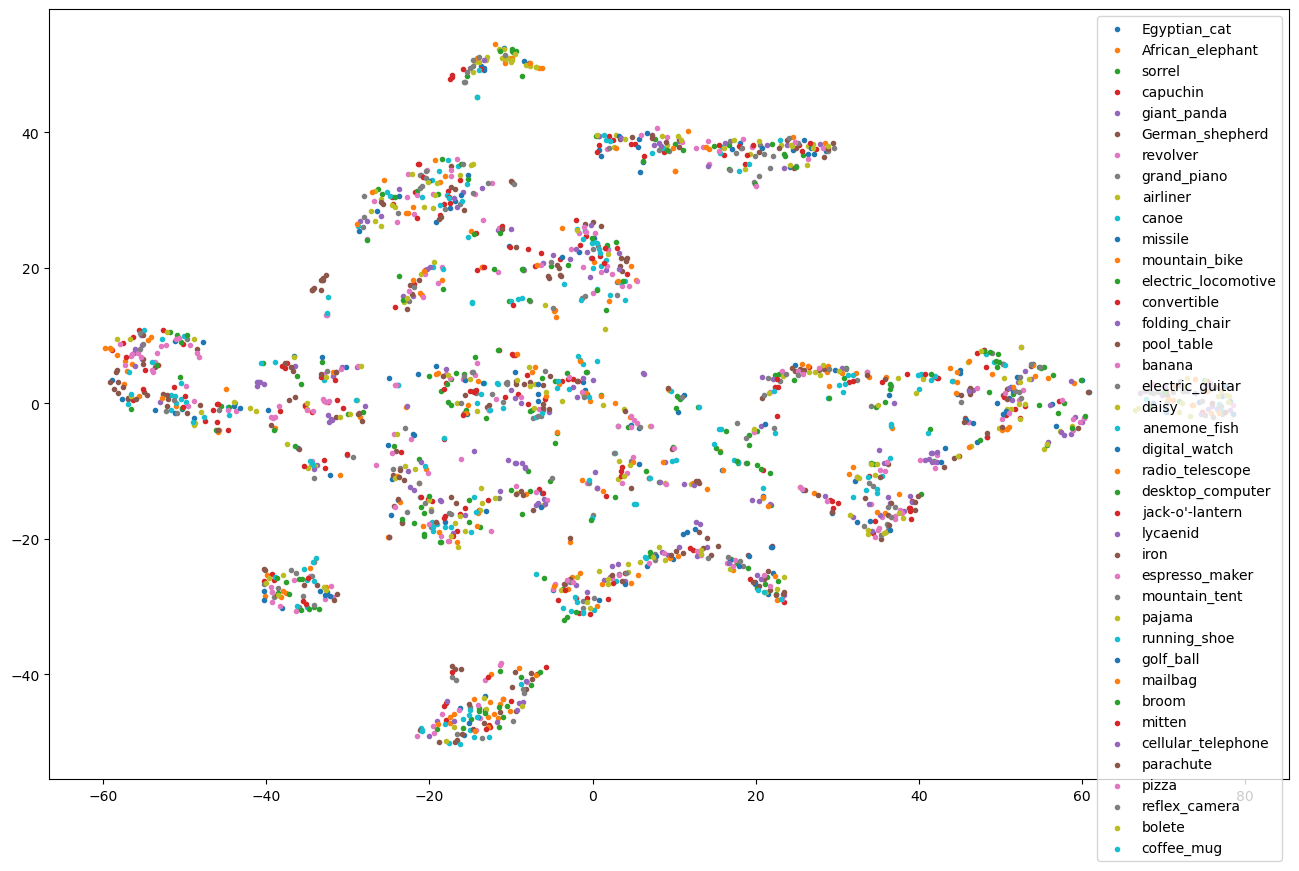

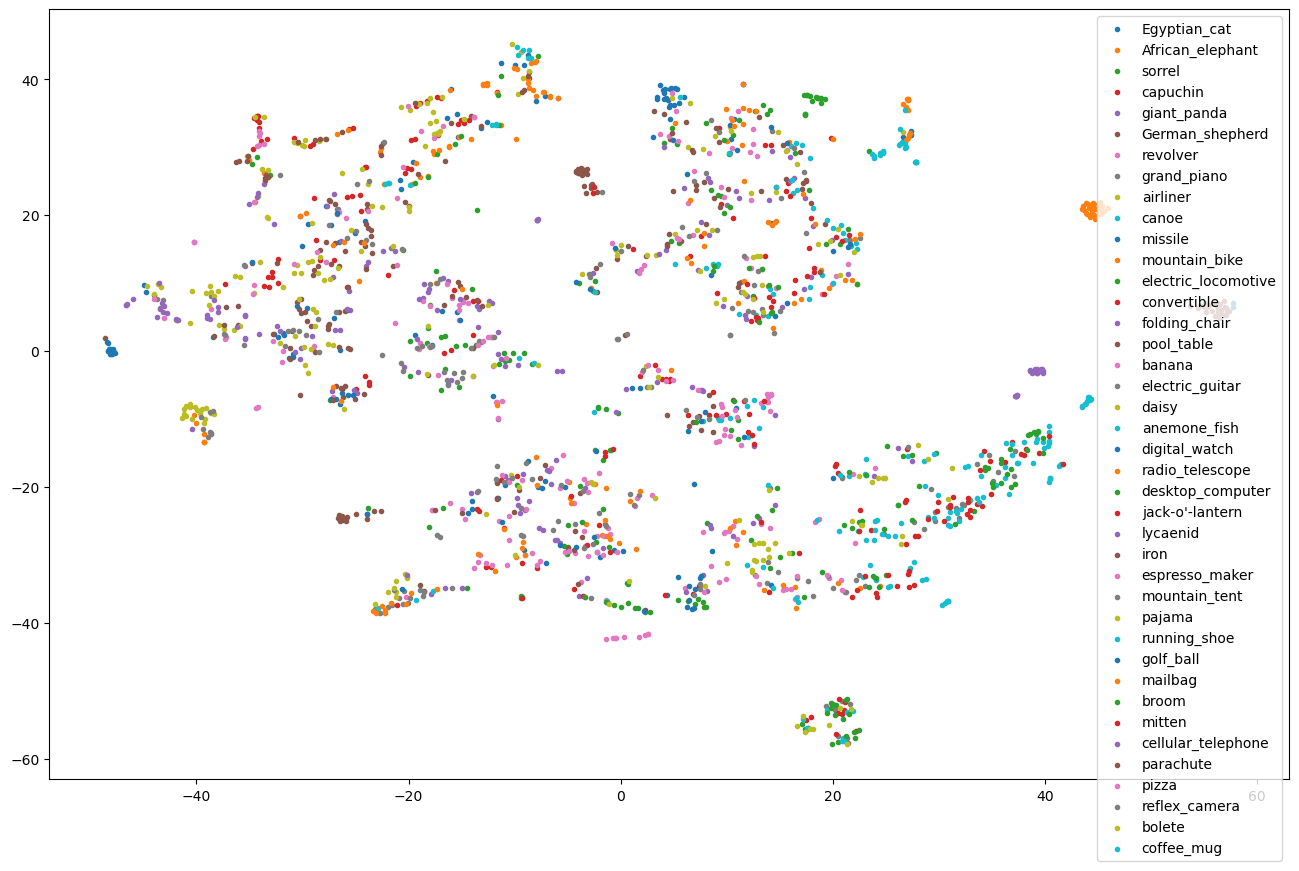

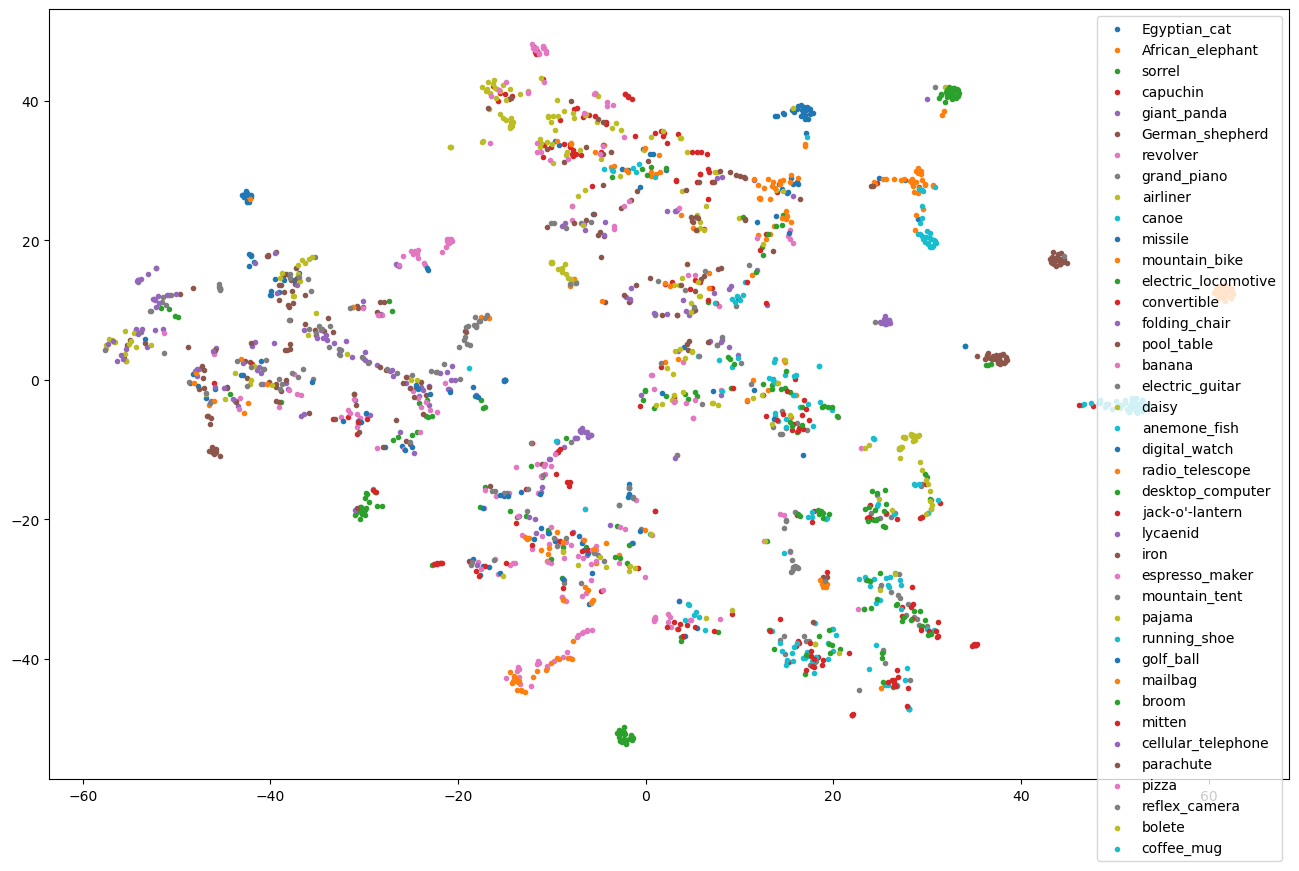

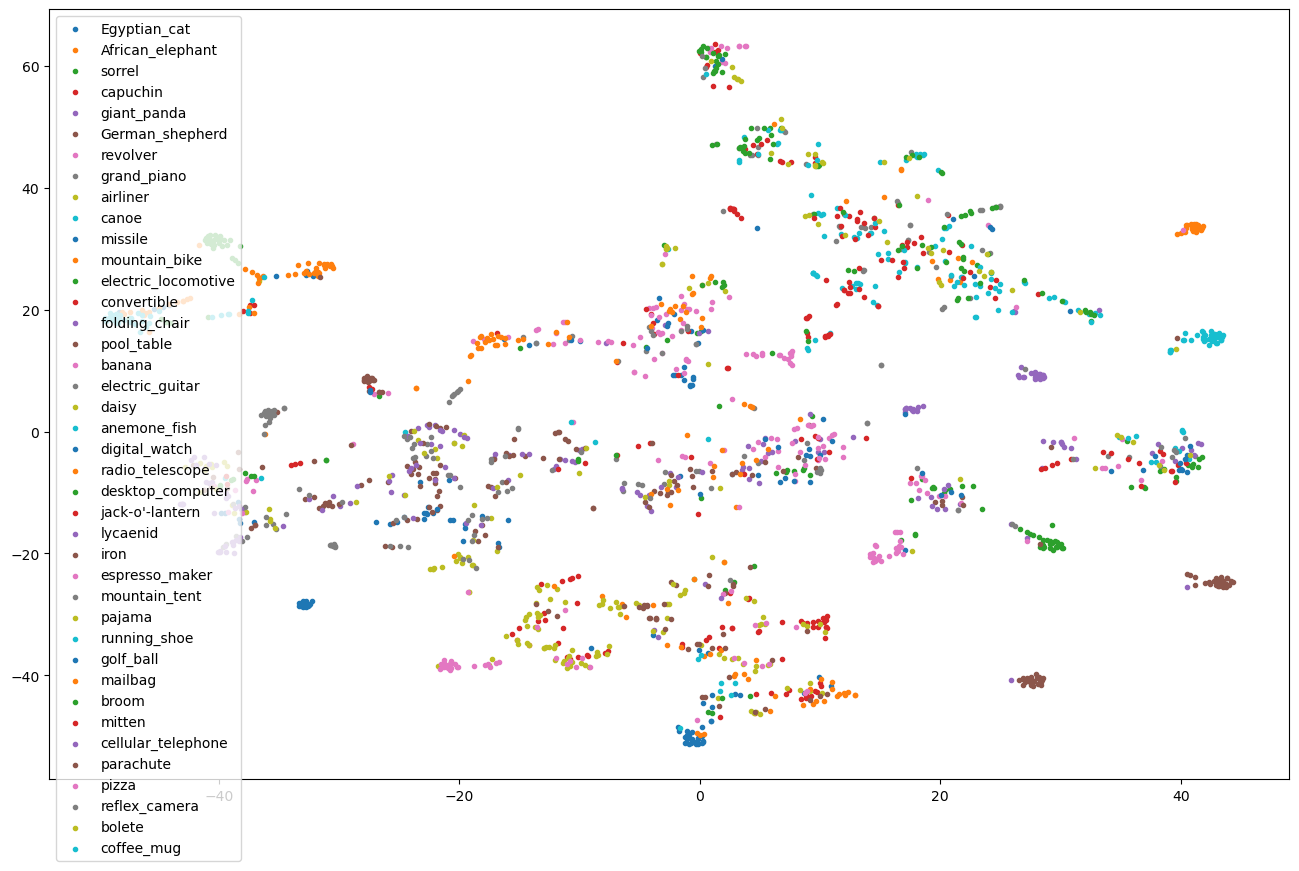

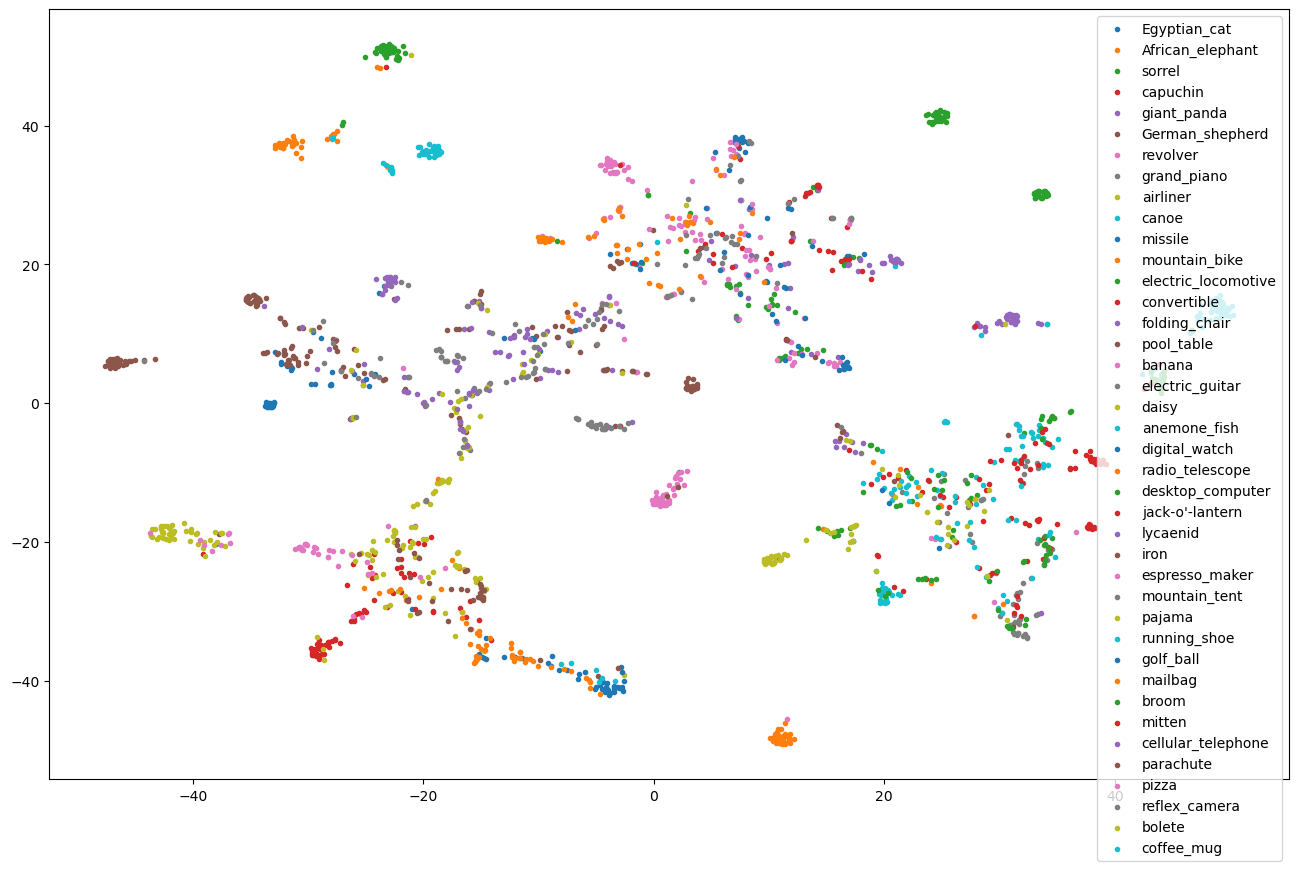

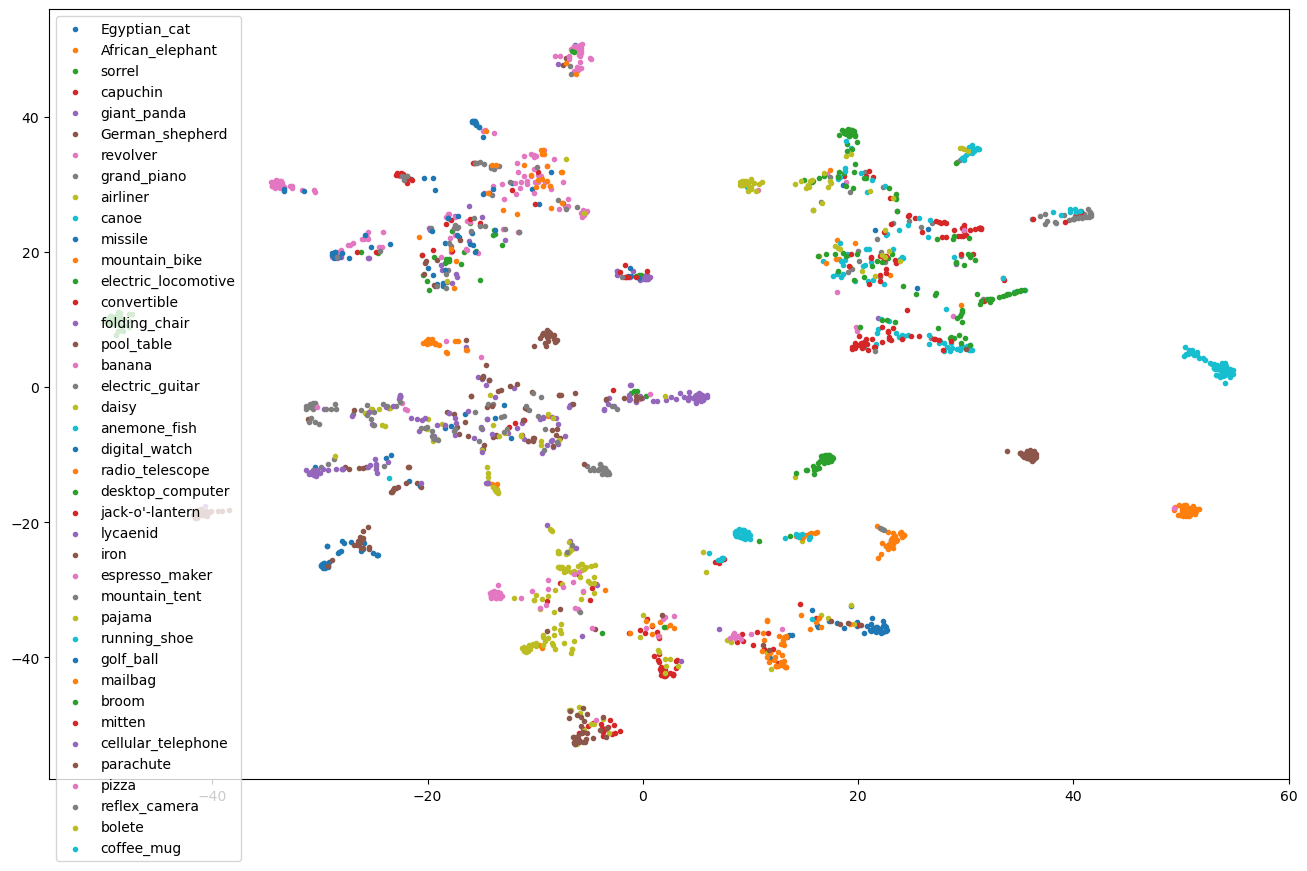

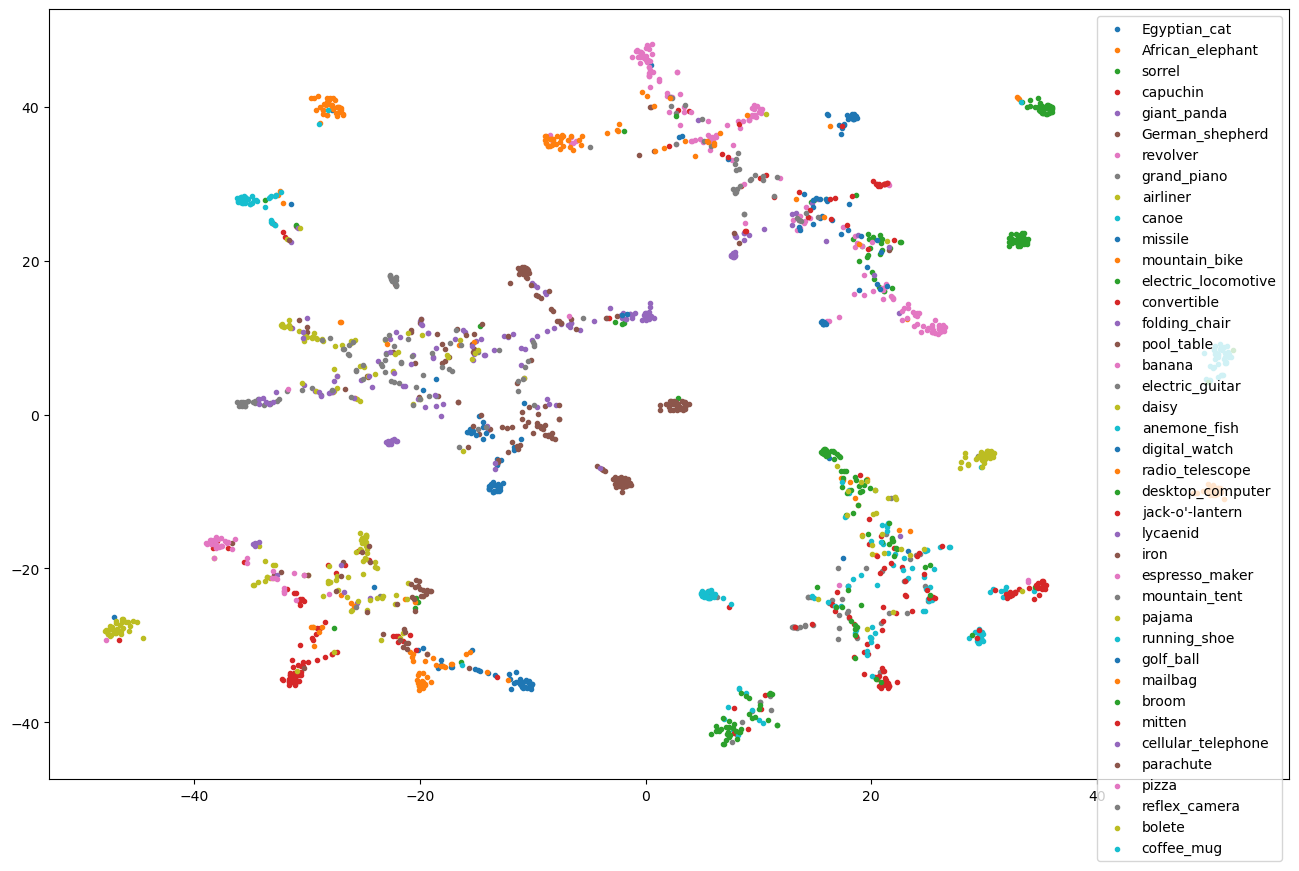

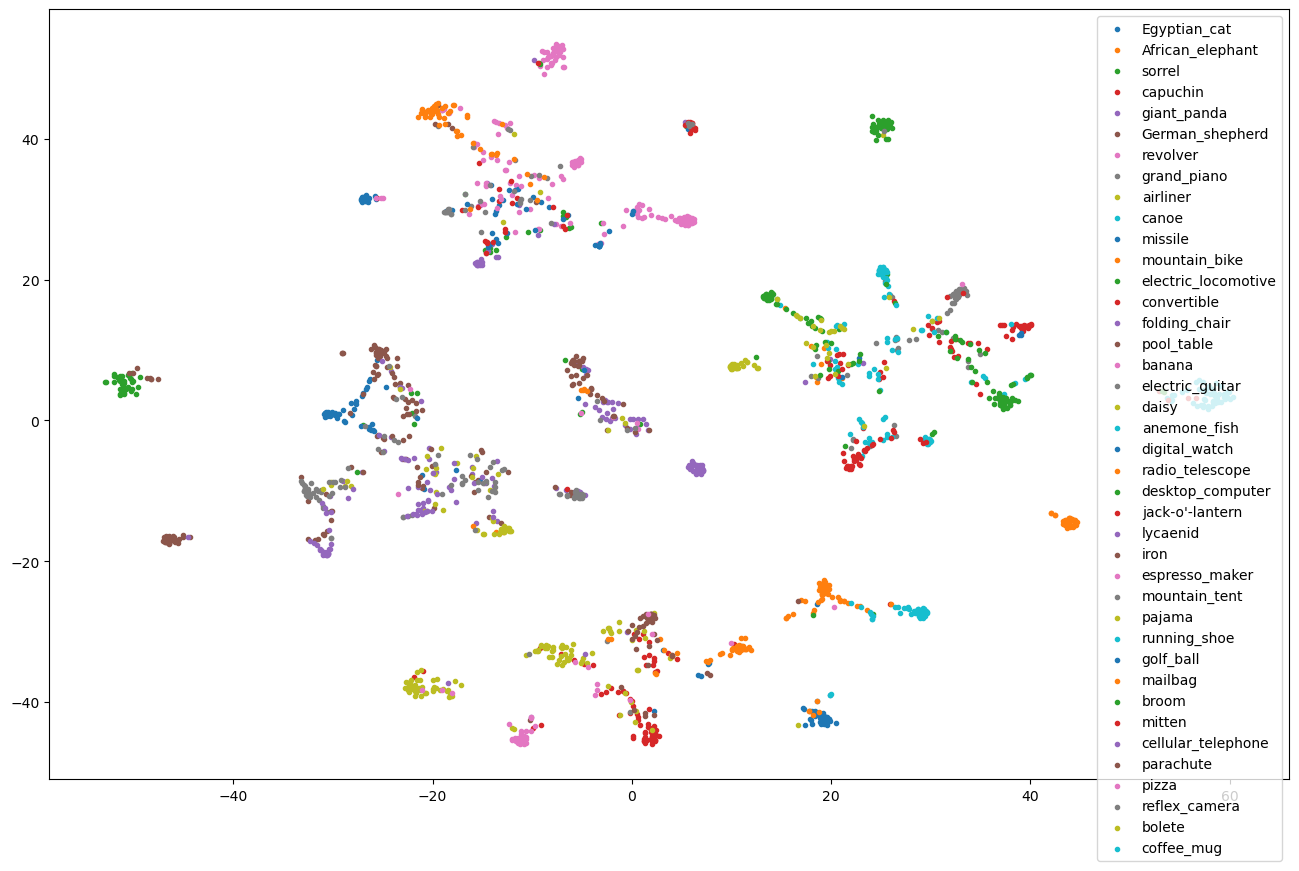

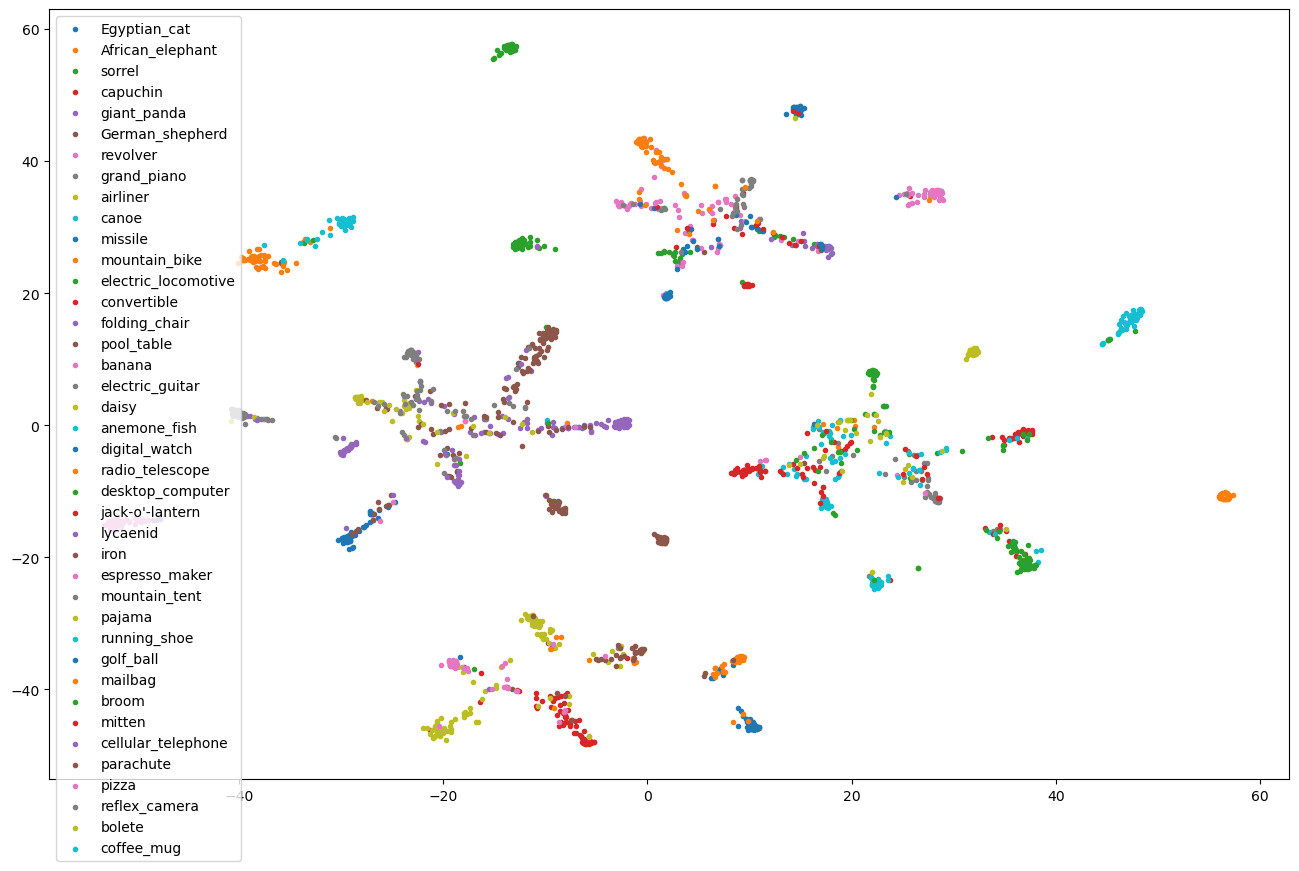

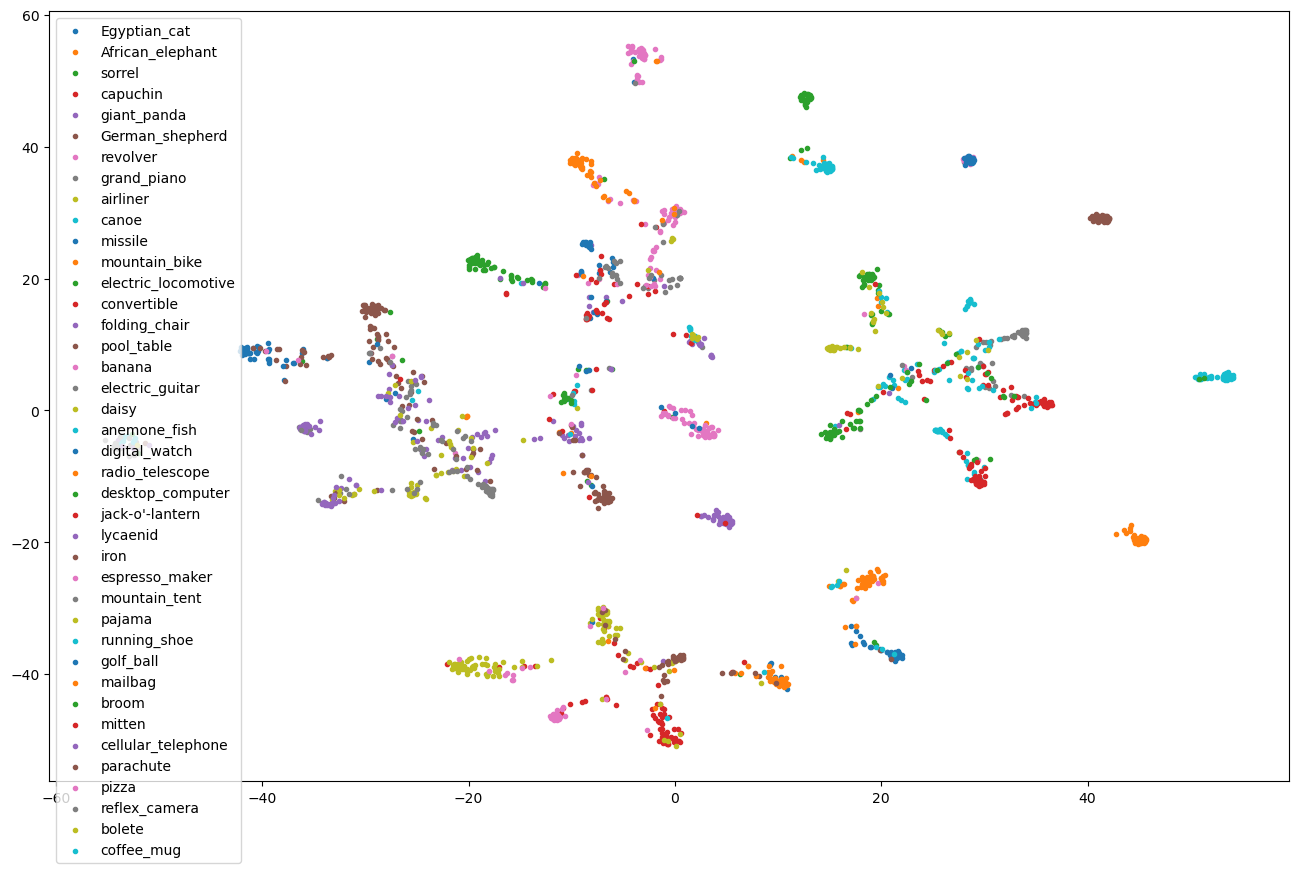

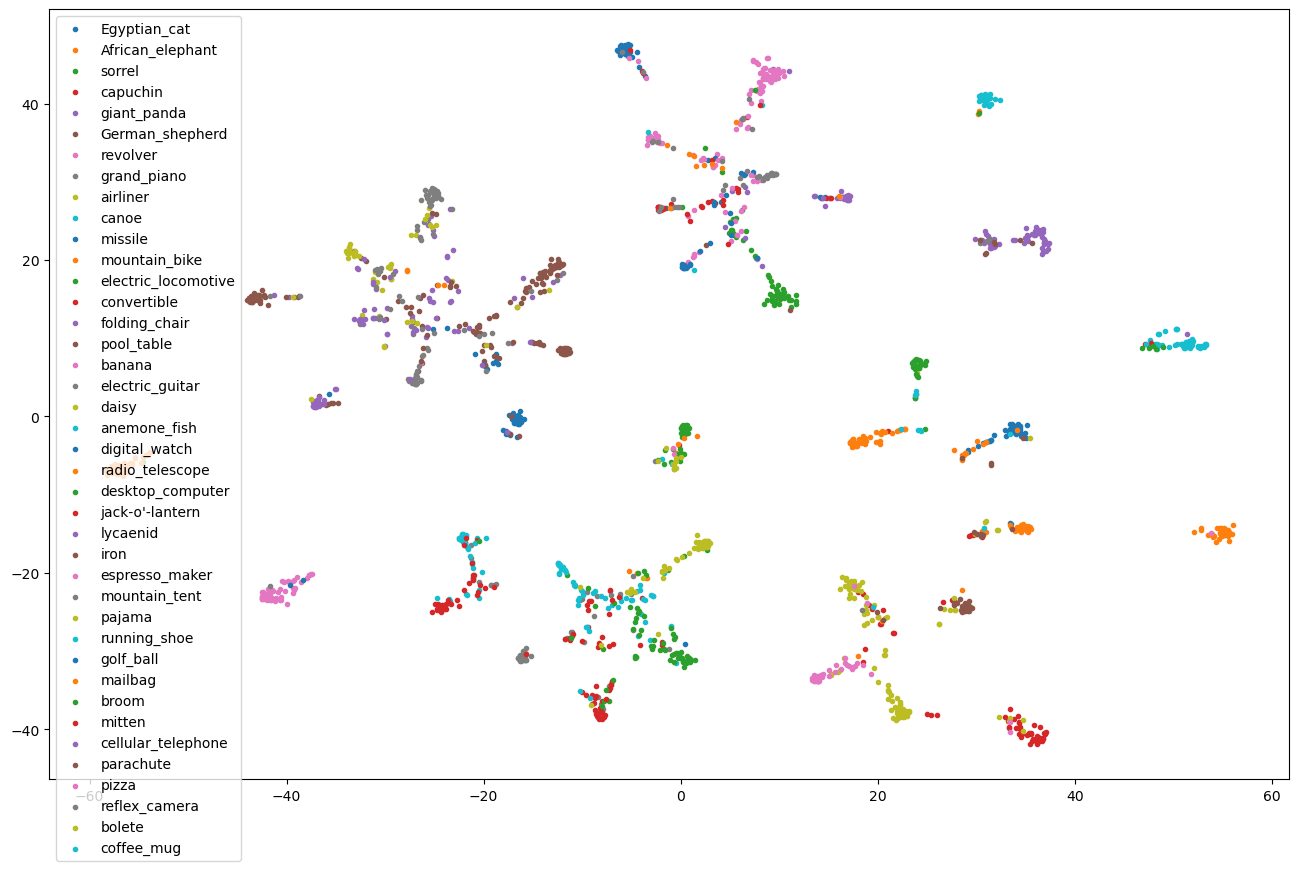

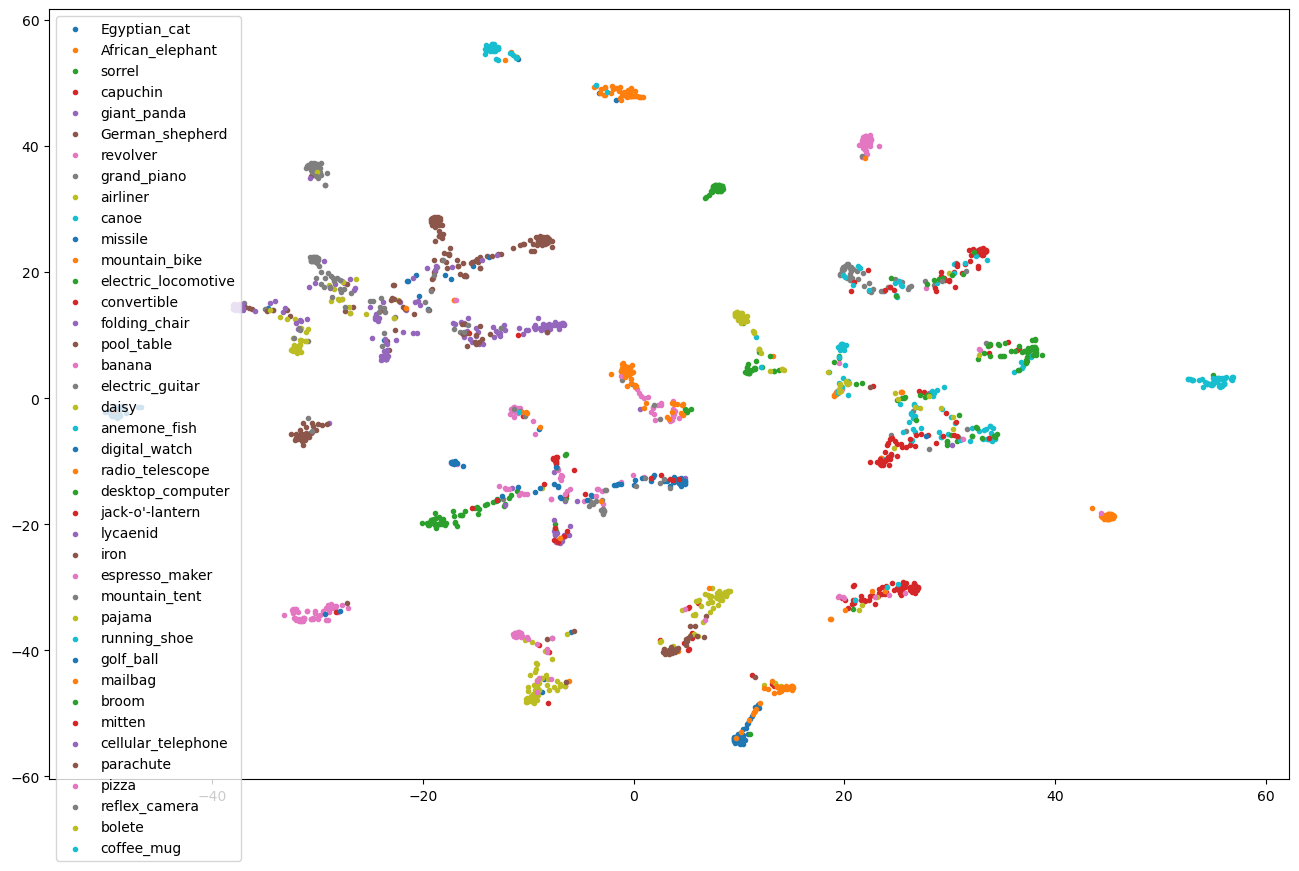

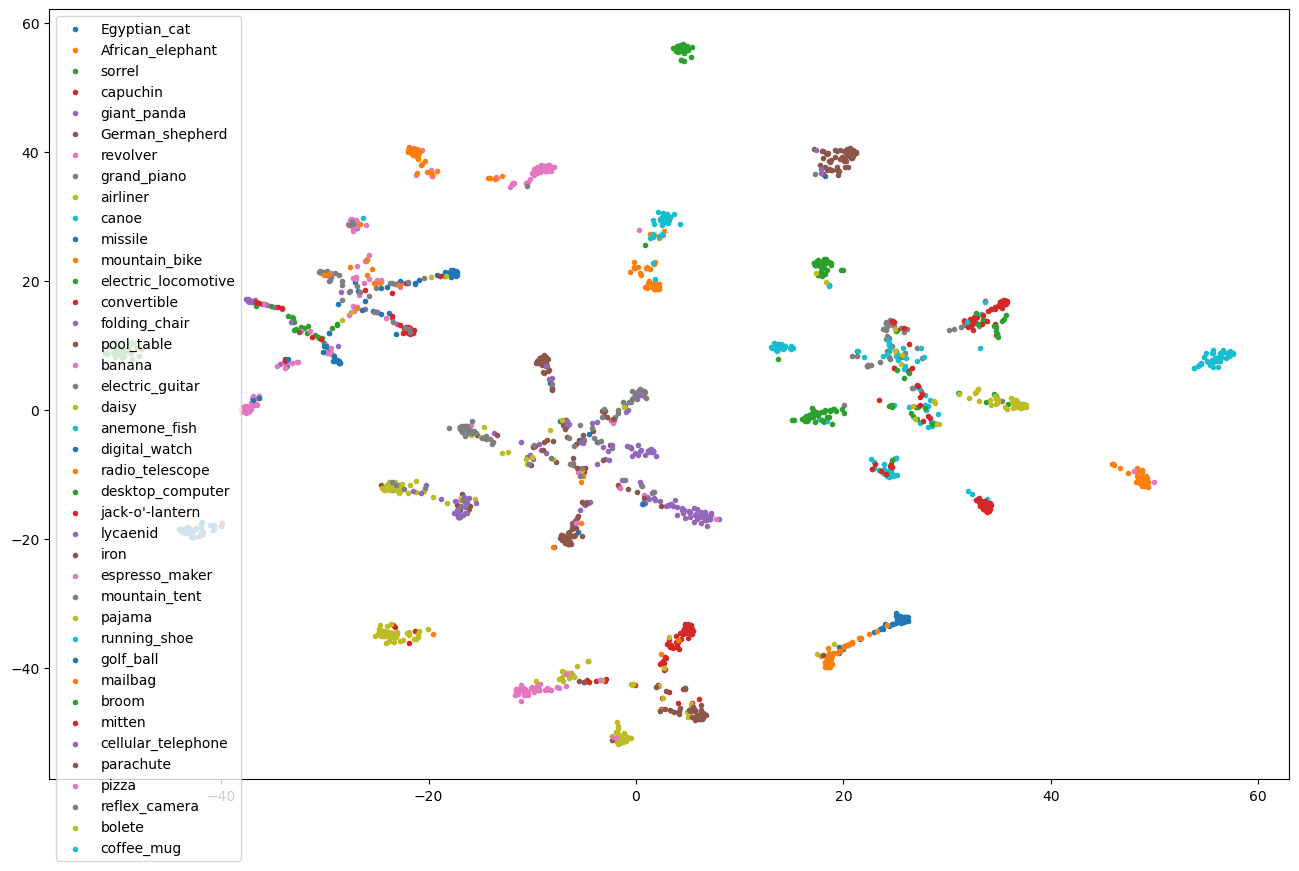

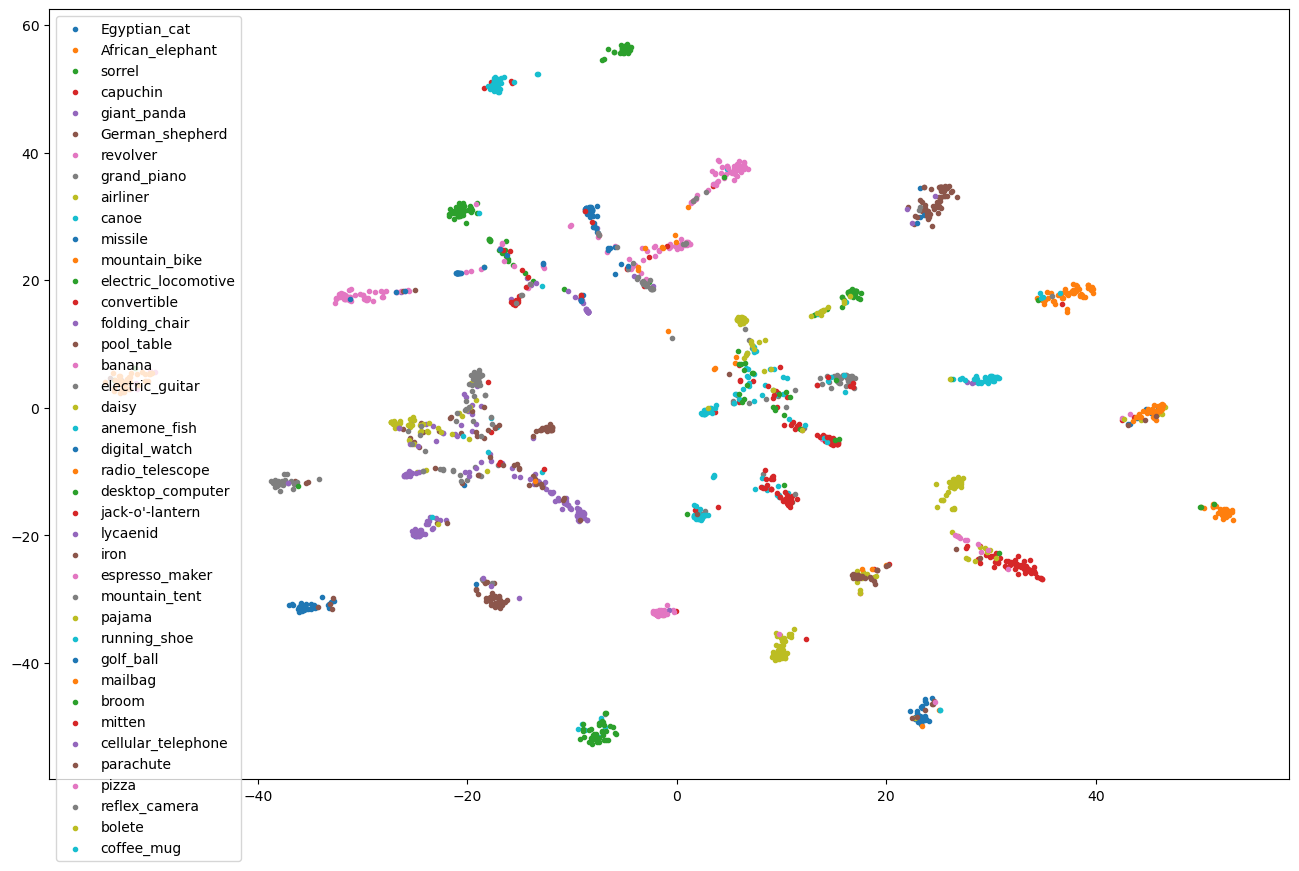

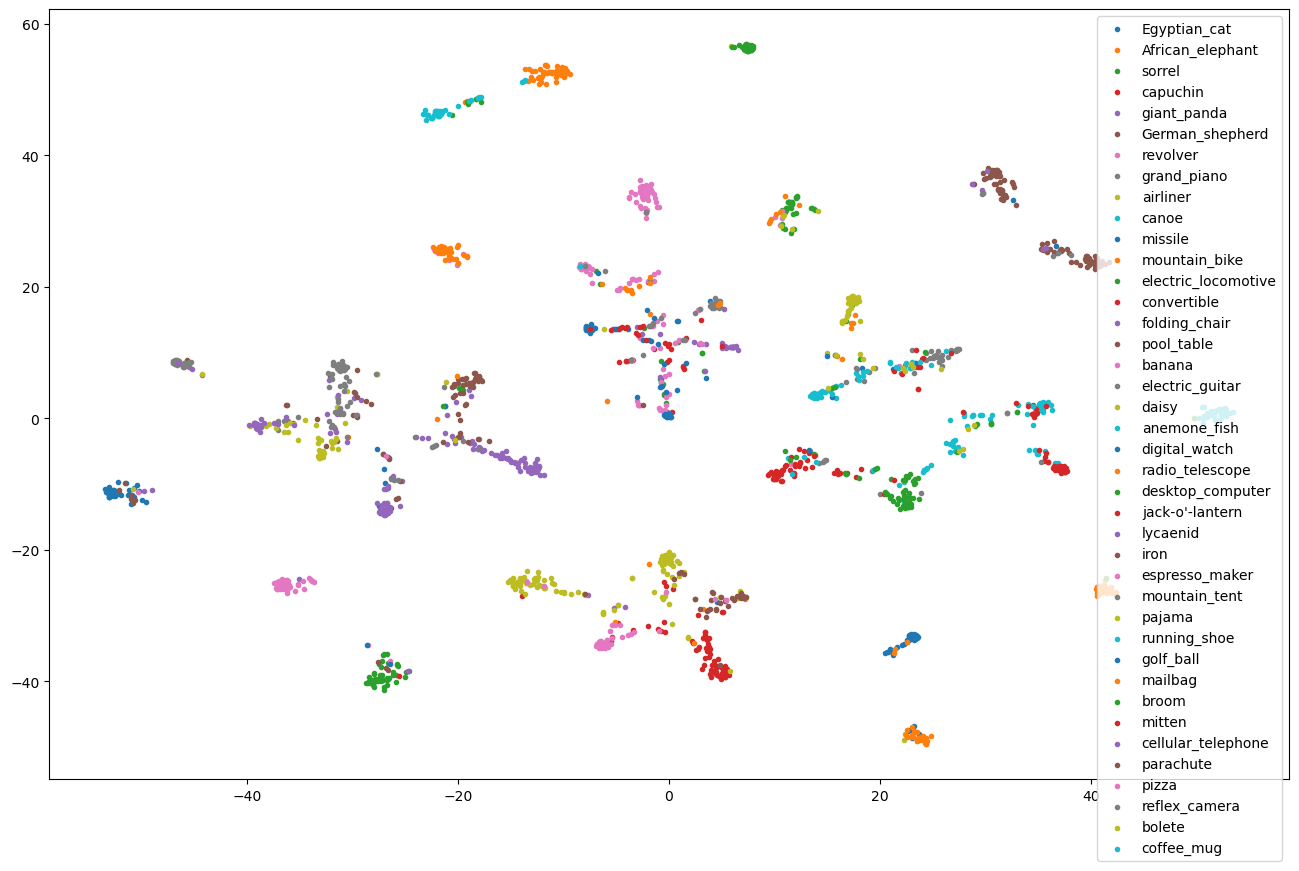

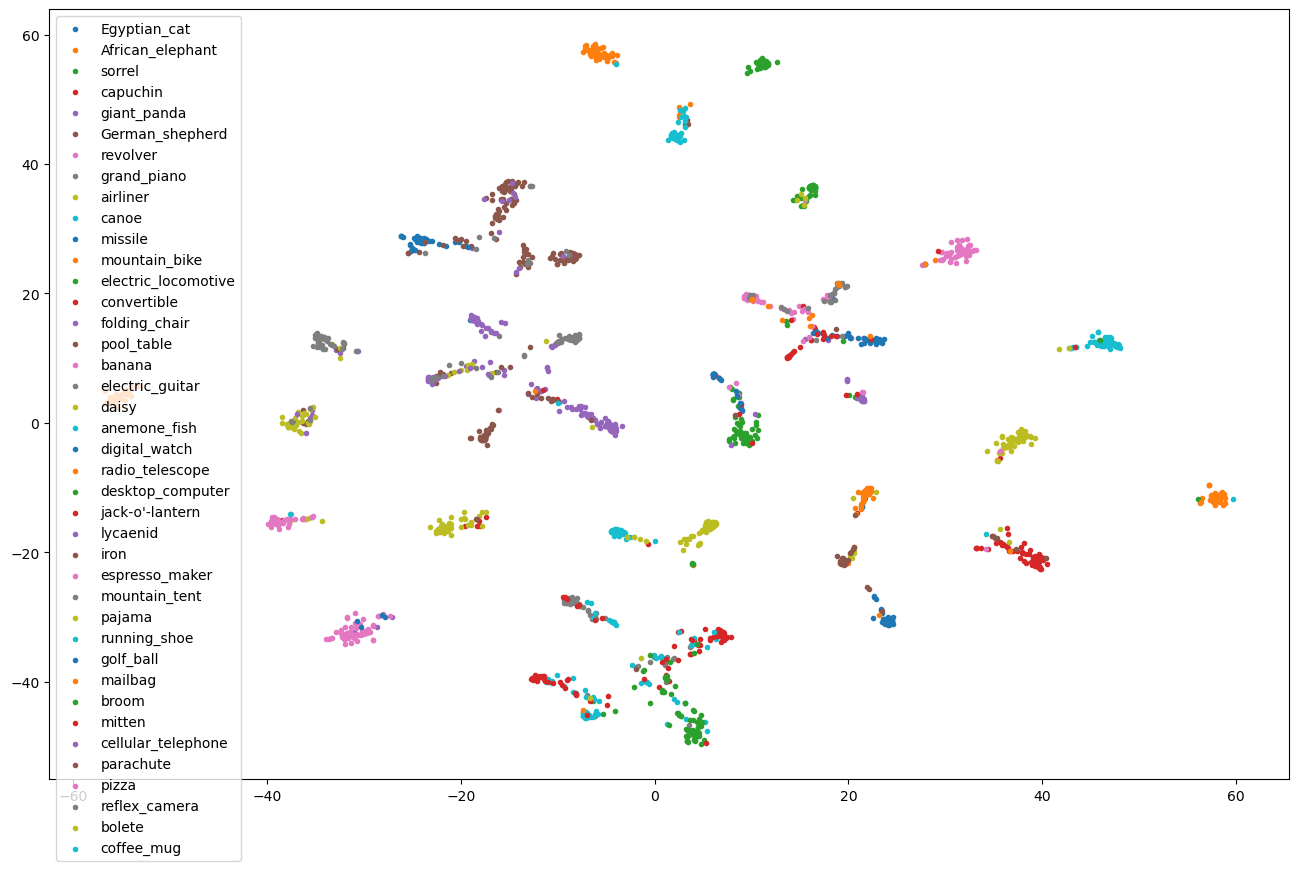

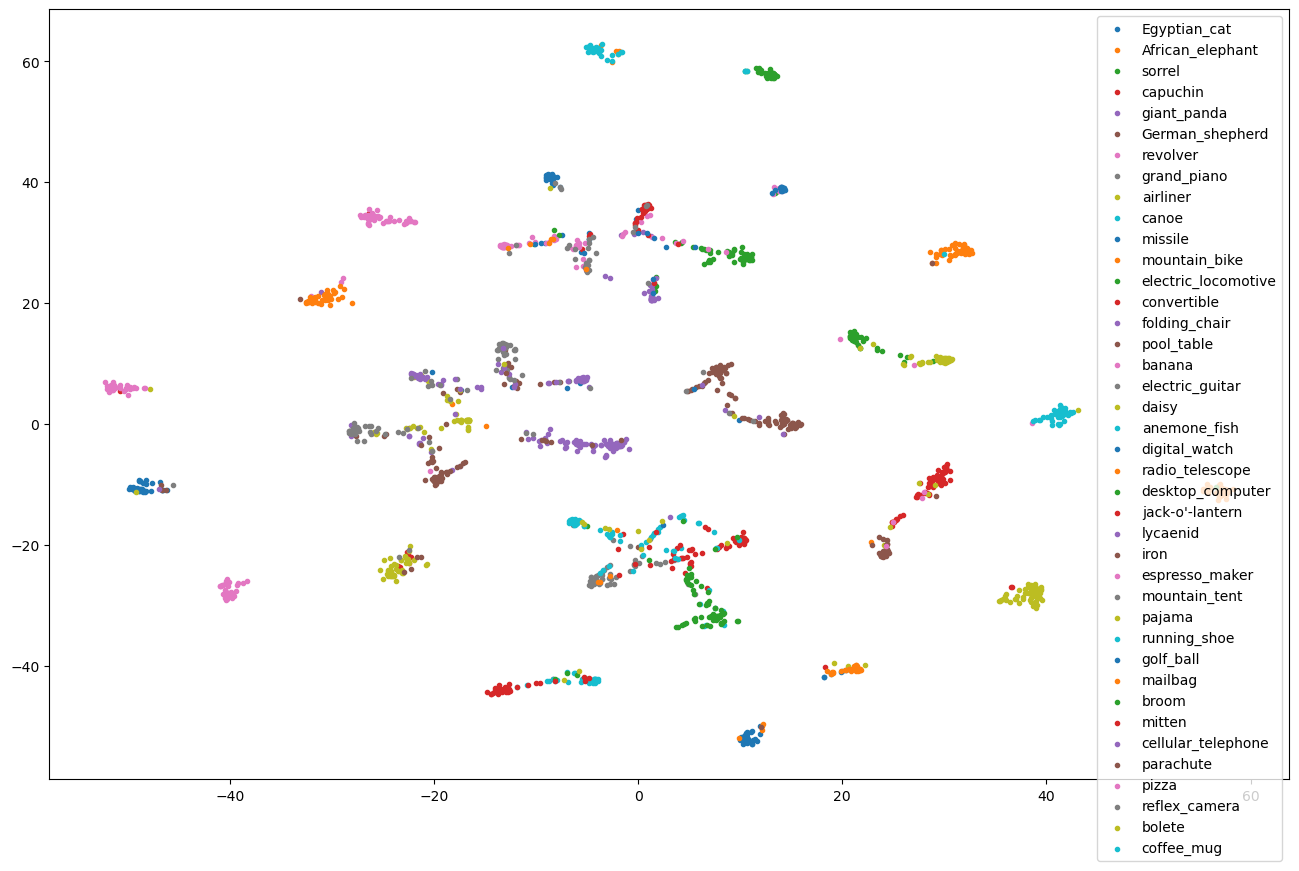

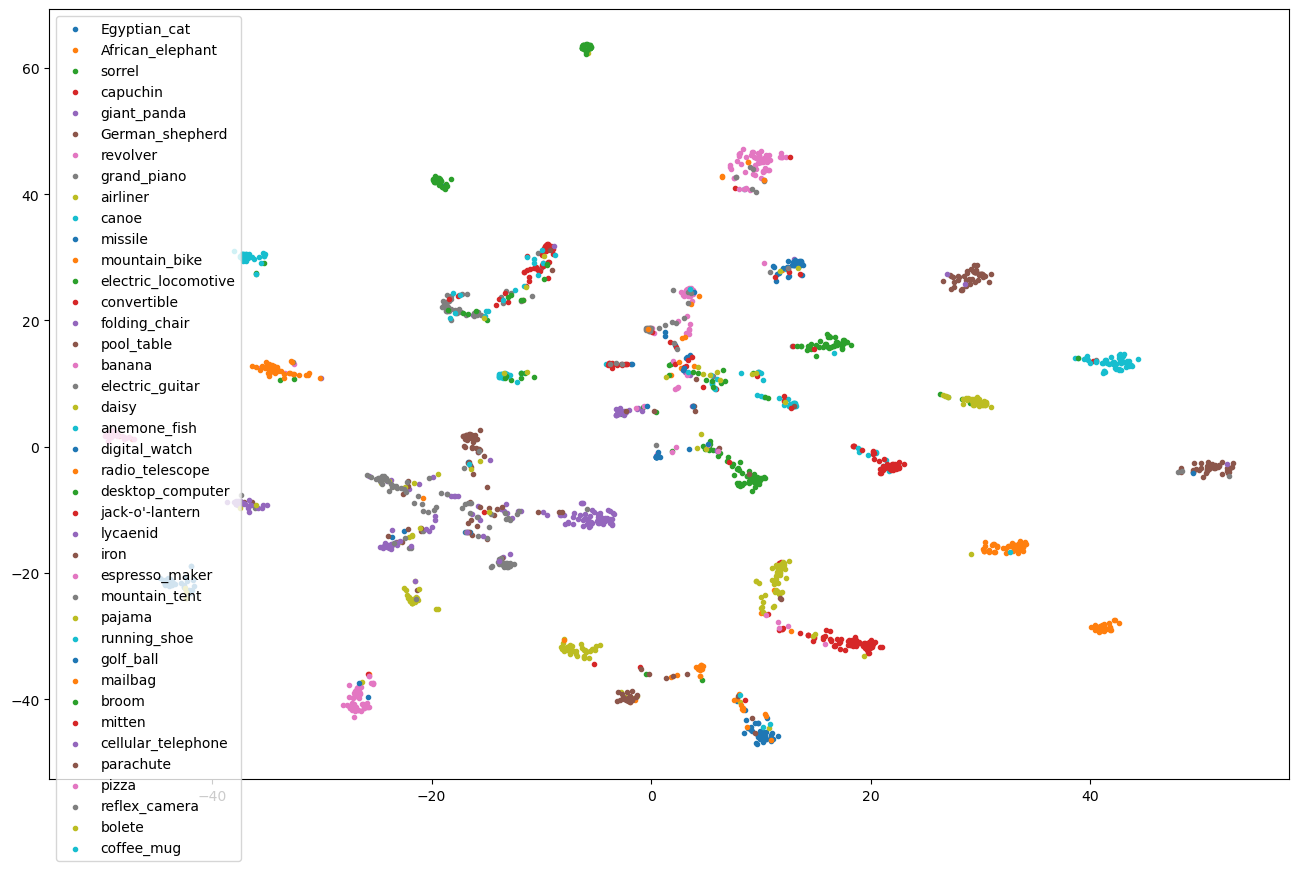

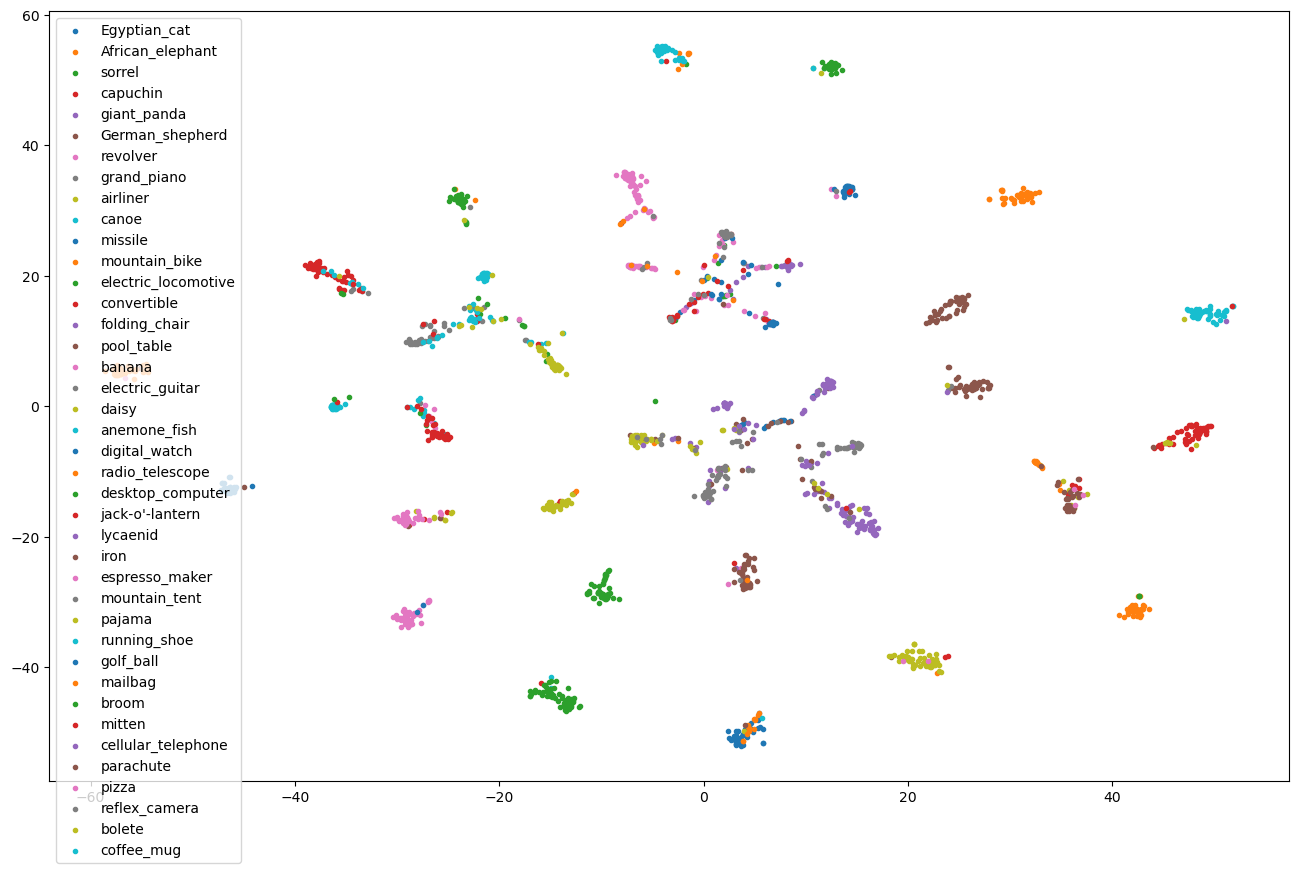

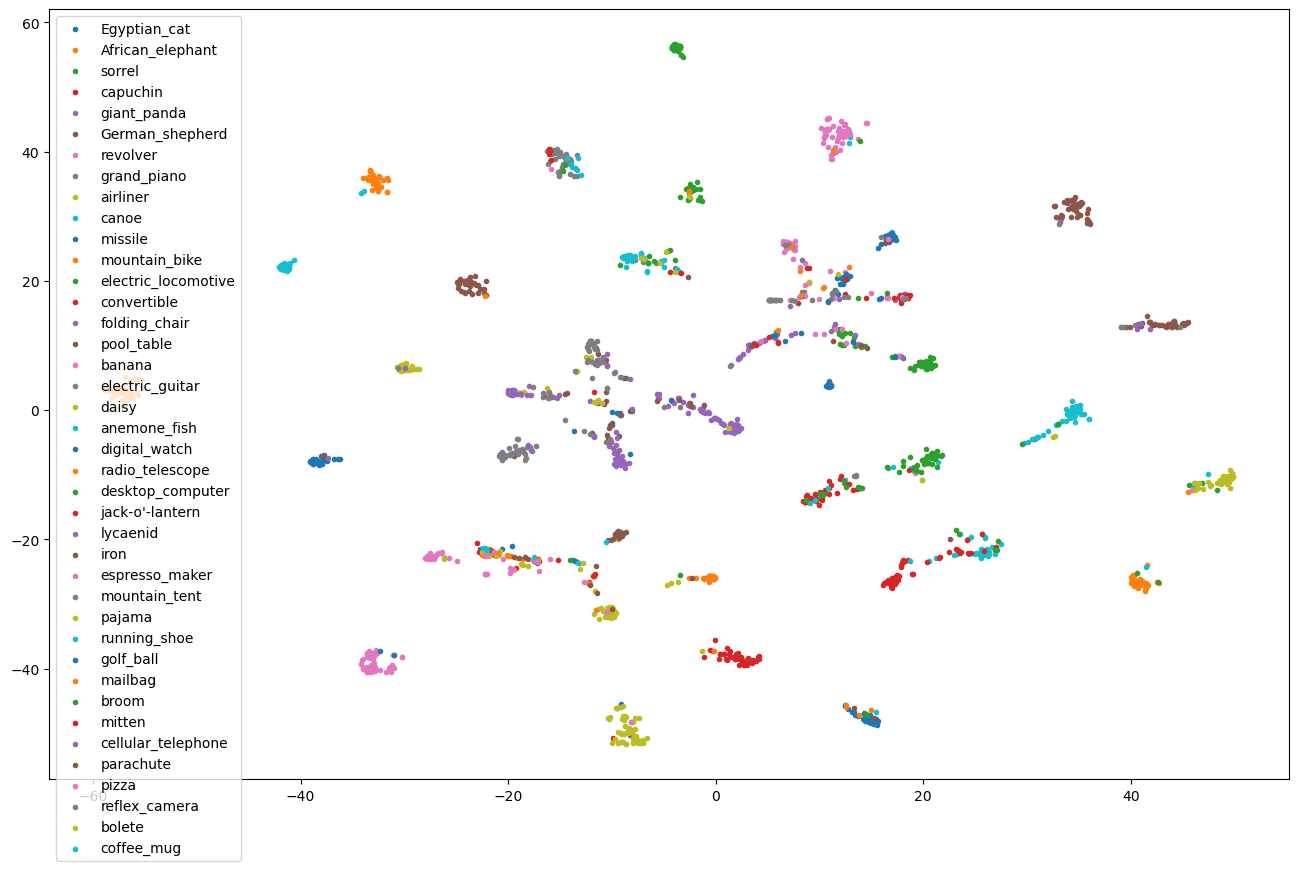

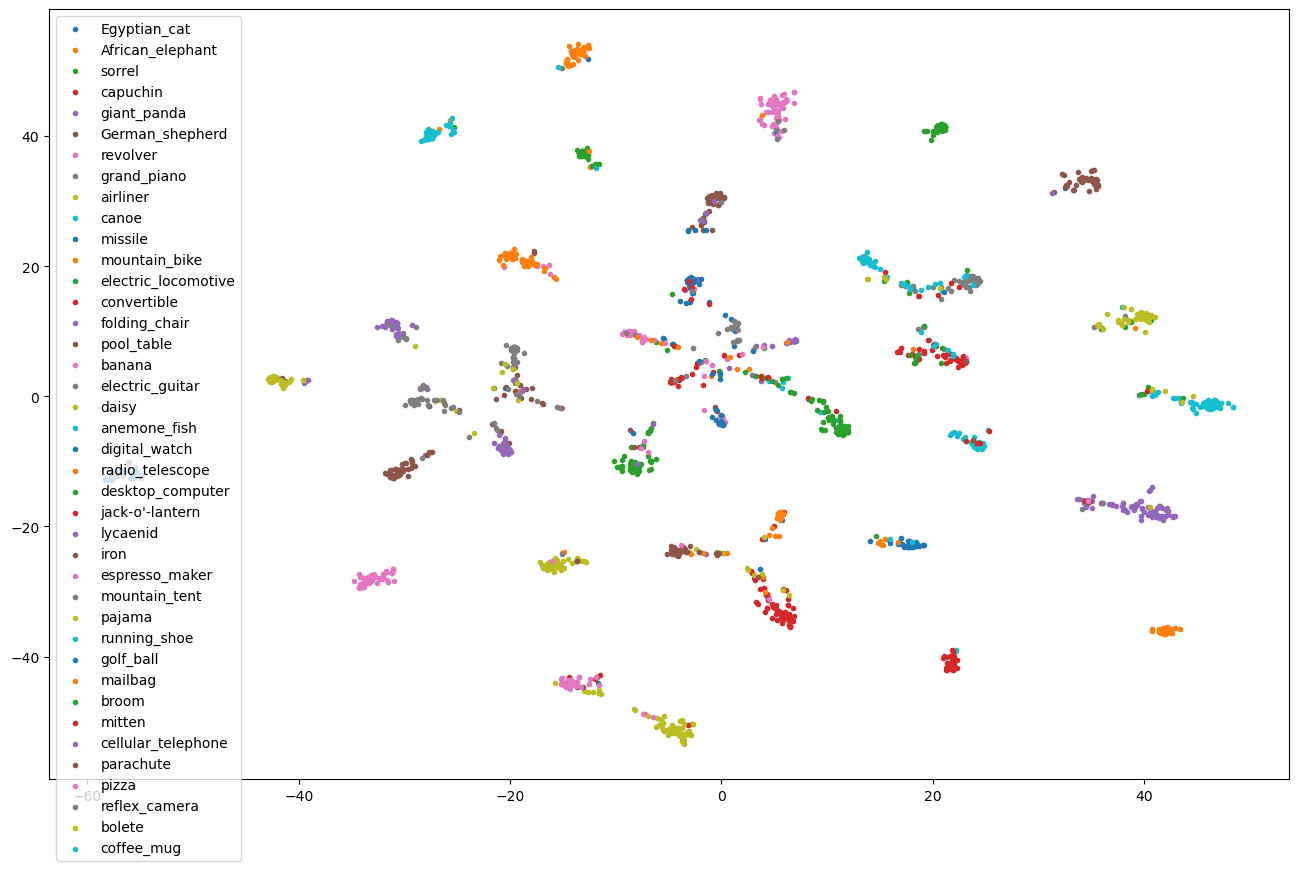

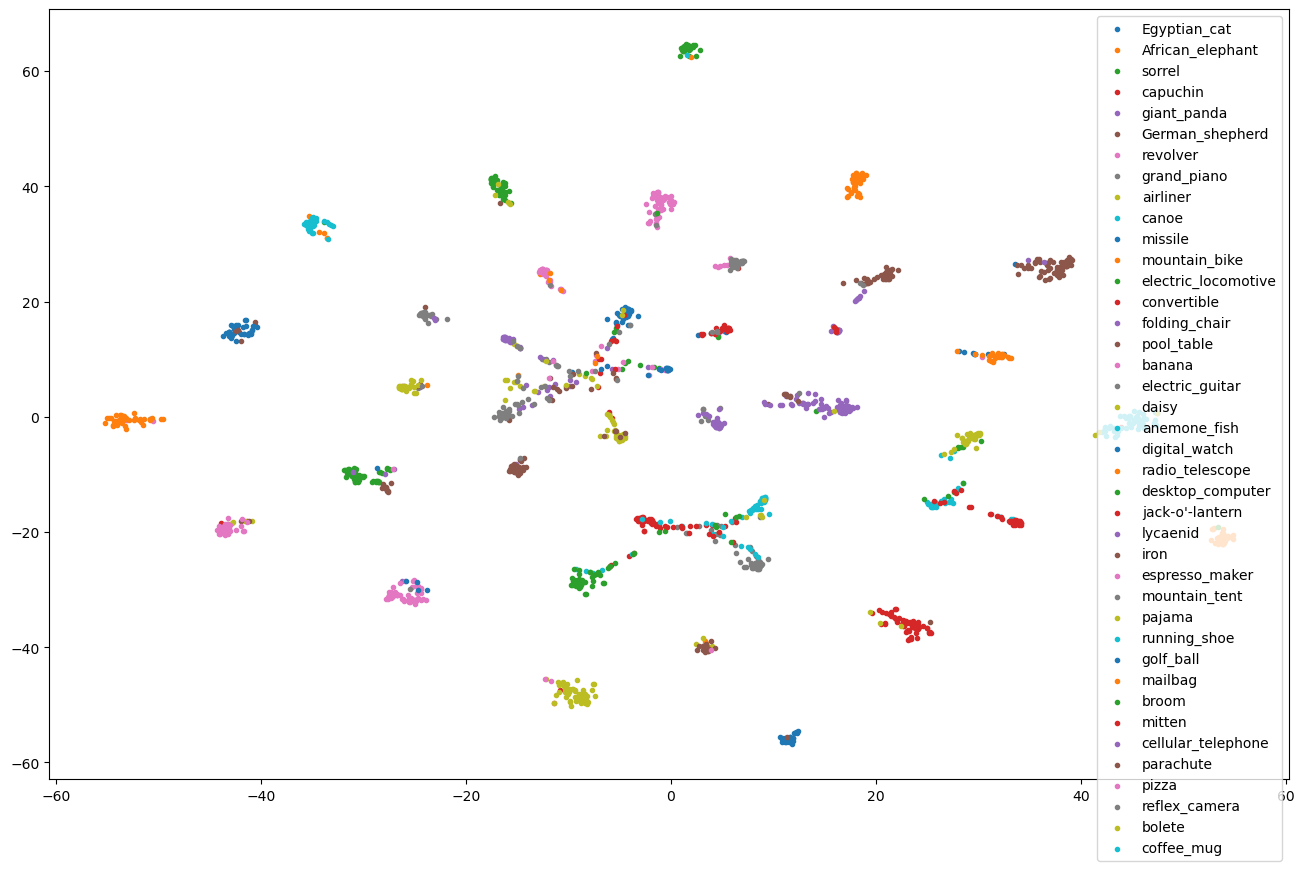

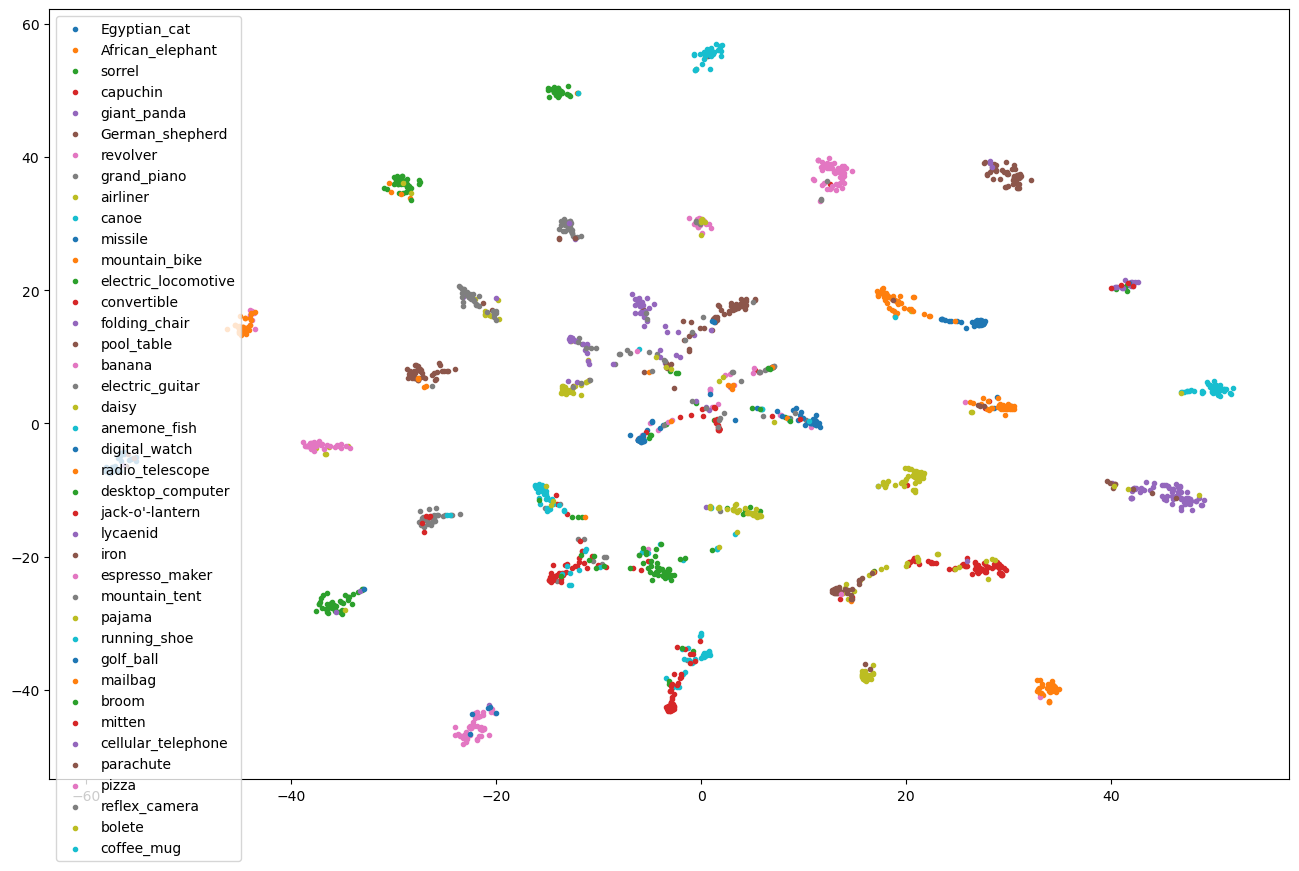

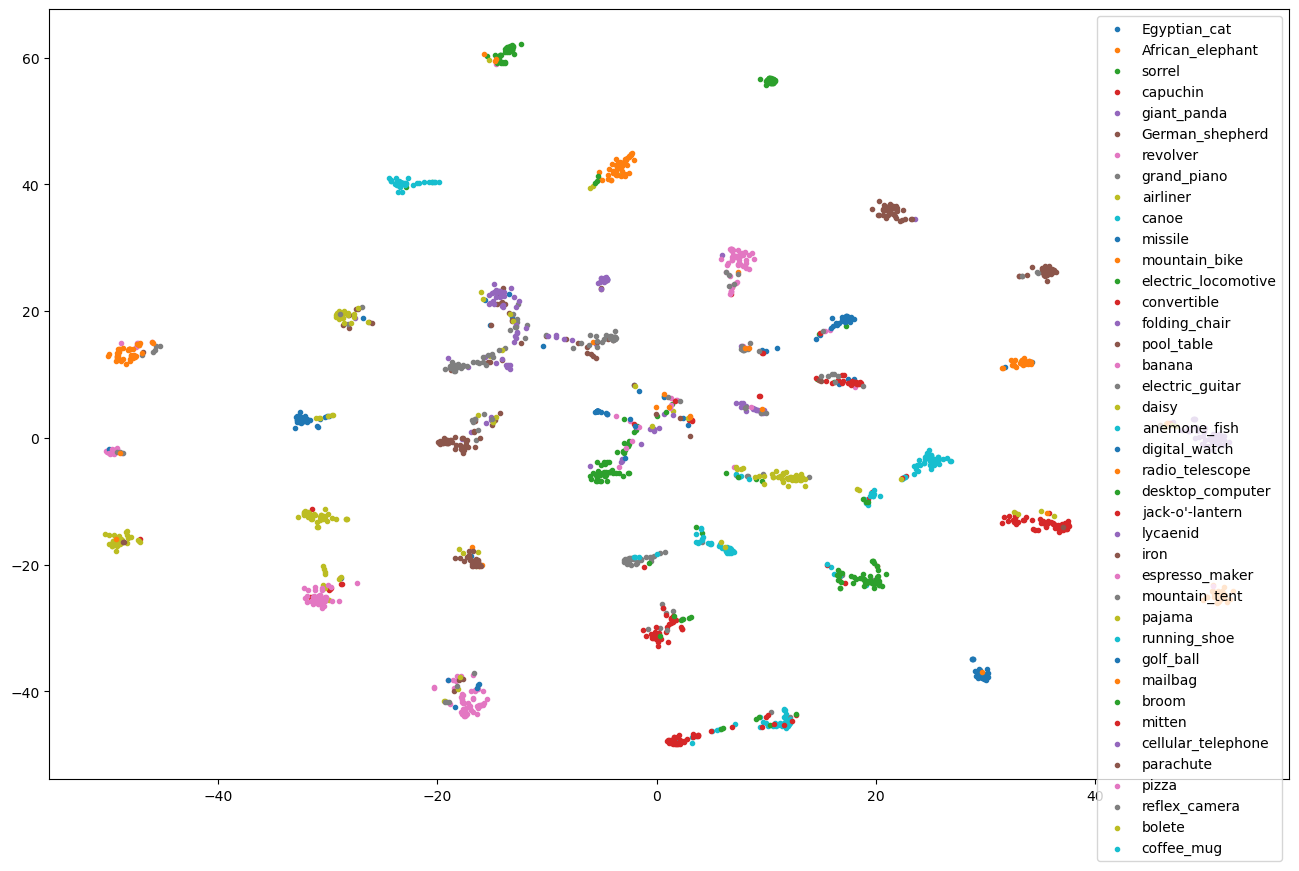

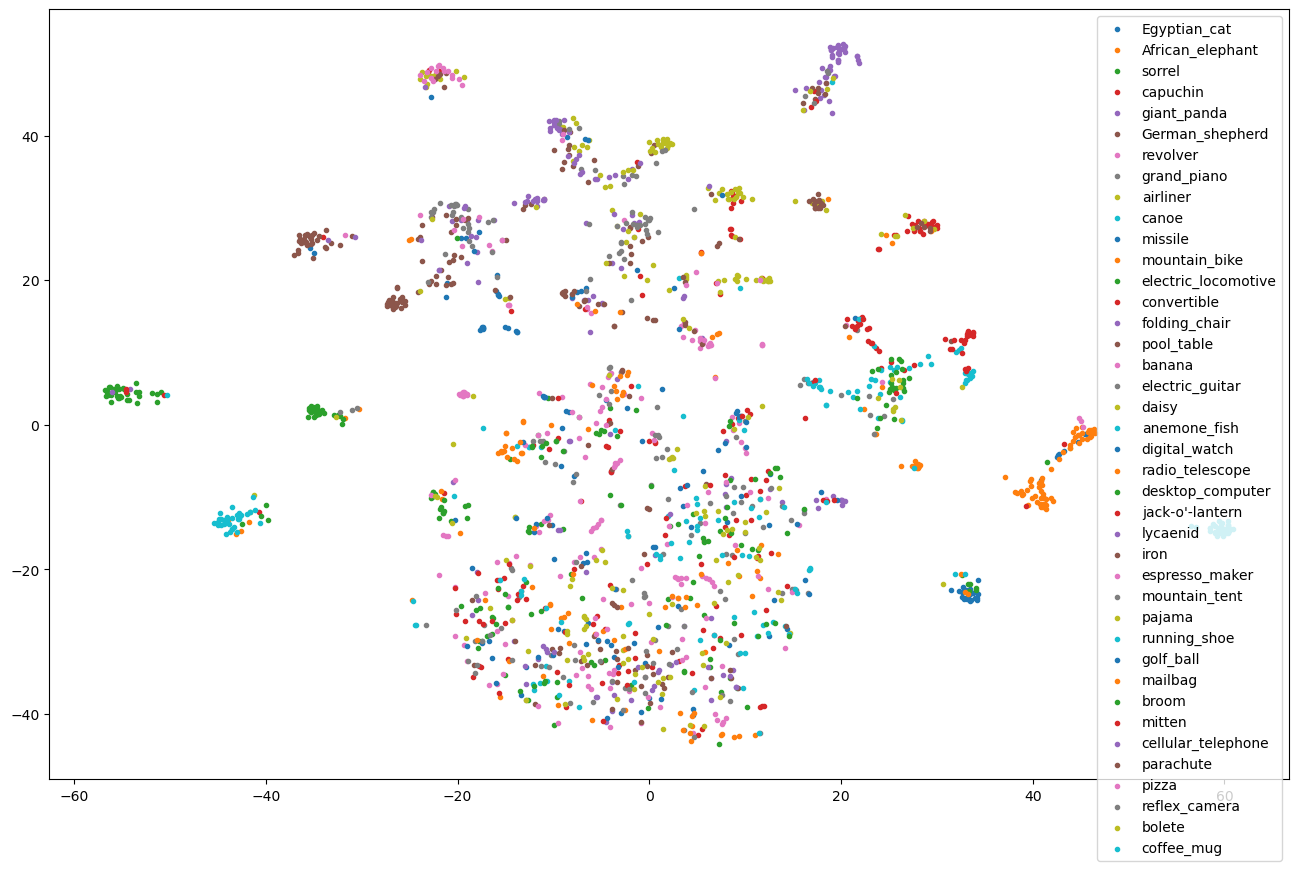

: 

In [17]:
model = SampleLevelFeatureExtractorNN()
model.to(device)

now = datetime.now()
now_hm = now.strftime("%H:%M")

logger = TensorBoardLogger(
    save_dir="/home/choi/BrainDecoder/lightning_logs/SampleLevelFeatureExtraction",
    name=f"{now_hm}_{config['optimizer']}_{config['lr']}_{config['scheduler']}_weight-decay_{config['weight_decay']}_lambda-factor_{config['lambda_factor']}",
    version=now.strftime("%Y-%m-%d %H:%M:%S"),
)

lr_monitor = LearningRateMonitor(logging_interval="epoch")

trainer = Trainer = L.Trainer(
    max_epochs=500,
    logger=logger,
    callbacks=[lr_monitor],
    accelerator="gpu",
    devices=[gpu_id],
)
trainer.fit(model, train_dataloaders=loaders["train"], val_dataloaders=loaders["val"])

In [ ]:
img_path = (
    "/home/choi/BrainDecoder/dataset/imageNet_images/n02106662/n02106662_10232.JPEG"
)
pil_img = Image.open(img_path)
image = preprocess(pil_img).unsqueeze(0).to(device)
text = clip.tokenize(["german shepard", "a dog", "a cat"]).to(device)

np_img = np.array(pil_img)
plt.imshow(np_img)
plt.show()

In [ ]:
img_path = (
    "/home/choi/BrainDecoder/dataset/imageNet_images/n02106662/n02106662_10232.JPEG"
)
text = ["an image of a dog", "hi"]
# text = "an image of a dog"
pil_img = Image.open(img_path)
image = preprocess(pil_img).unsqueeze(0).to(device)
text = clip.tokenize(text).to(device)
print(text)
print(text.shape)

with torch.no_grad():
    image_features = model.encode_image(image)
    text_features = model.encode_text(text)
    print(text_features)
    print(text_features.shape)

    logits_per_image, logits_per_text = model(image, text)
    probs = logits_per_image.softmax(dim=-1).cpu().numpy()

print(logits_per_image)
print(logits_per_text)
np.set_printoptions(suppress=True)
print(probs)
print(np.max(probs))
print(np.argmax(probs))
print(image_features.shape)
print(text_features.shape)
print(type(text_features))

In [ ]:
from lavis.models import load_model_and_preprocess

img_path = (
    "/home/choi/BrainDecoder/dataset/imageNet_images/n02106662/n02106662_10232.JPEG"
)
pil_img = Image.open(img_path)

blip_model, vis_processors, _ = load_model_and_preprocess(
    name="blip_caption", model_type="base_coco", is_eval=True, device=device
)
pil_img = vis_processors["eval"](pil_img).unsqueeze(0).to(device)
blip_model.generate({"image": pil_image})